# Recurrent Inference Machine (RIM) on a toy problem

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from itertools import cycle
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as f
from torch.autograd import Variable

import torchvision.datasets as datasets
import torchvision.transforms as transforms

from sklearn.utils import shuffle
from IPython.display import clear_output

In [2]:
colormap = np.array(plt.rcParams['axes.prop_cycle'].by_key()['color'])

## Create the simulator and the data
The simulator is defined as $y=x + n$ where $n \sim \mathcal{N}(0,\sigma^2)$ with $\sigma$ known. The loss will then be defined to be $\mathcal{L}(x,y)=\frac{1}{2} x^T x - y^T x$.

### Constants

In [3]:
nb_samples = 100
batch_size = 16
time_max_rim = 5
time_max_gd = 60
nb_epochs = 2
sigma_noise = 0.2

size_train = 400
size_test = 100

In [4]:
folder_mnist = "/datasets/mnist/"

### Simulator

In [12]:
a = np.array([0.5,1.2])
np.minimum(1,a)

array([ 0.5,  1. ])

In [13]:
def simulate(x, sigma=0.1):
    return np.minimum(1, np.maximum(0, x + np.random.normal(0, sigma, x.shape)))

In [14]:
def loss(x, y):
    return 0.5 * x.T.dot(x) -  y.T.dot(x)

In [15]:
def gradient(x, y):
    return x - y

### Data

#### Training

In [16]:
mnist_train = datasets.MNIST(root=folder_mnist, train=True, download=False, transform=transforms.ToTensor())

In [17]:
X_train = mnist_train.train_data.numpy()[:size_train].reshape(size_train, 784) / 255
Y_train = simulate(X_train, sigma_noise)
X0_train = Y_train

#### Test

In [20]:
mnist_test = datasets.MNIST(root=folder_mnist, train=False, download=False, transform=transforms.ToTensor())

In [21]:
X_test = mnist_test.test_data.numpy()[:size_test].reshape(size_test, 784) / 255
Y_test = simulate(X_test, sigma_noise)
X0_test = Y_test

#### Visualization

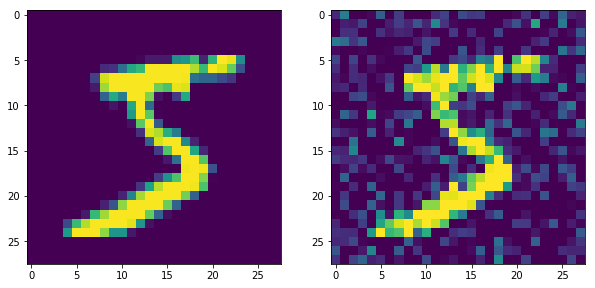

In [22]:
plt.rcParams['figure.figsize'] = (10, 8)

plt.subplot(1,2,1)
plt.imshow(X_train[0].reshape(28,28))

plt.subplot(1,2,2)
plt.imshow(Y_train[0].reshape(28,28))

## RNN
Deep RNN based on [this diagram](https://stackoverflow.com/questions/48302810/whats-the-difference-between-hidden-and-output-in-pytorch-lstm?rq=1)

In [319]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, init_variance=0.1):
        super(RNN, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        
        self.h1_layer = nn.Linear(input_size + hidden_size, hidden_size)
        self.h2_layer = nn.Linear(hidden_size*2, hidden_size)
        self.h3_layer = nn.Linear(hidden_size*2, hidden_size)
        self.output_layer = nn.Linear(hidden_size*2, output_size)
        
        nn.init.xavier_normal(self.h1_layer.weight, init_variance)
        nn.init.xavier_normal(self.h2_layer.weight, init_variance)
        nn.init.xavier_normal(self.h3_layer.weight, init_variance)
        nn.init.xavier_normal(self.output_layer.weight, init_variance)
        
    def forward(self, xt, st):
        combined_h1 = torch.cat((xt, st[0]), 2)
        h1 = self.h1_layer(combined_h1)
        h1 = f.relu(h1)
        
        combined_h2 = torch.cat((h1,st[1]), 2)
        h2 = self.h2_layer(combined_h2)
        h2 = f.relu(h2)
        
        combined_h3 = torch.cat((h2,st[2]), 2)
        h3 = self.h3_layer(combined_h3)
        h3 = f.relu(h3)
        
        output = self.output_layer(combined_h3)
        
        return output, [h1, h2, h3]

# RIM

In [320]:
def weight_loss(t, T):
#     return t/T
    return 1

In [321]:
def psi(h):
    x = f.relu(h)
    x = 1-f.relu(-x+1)
    return x

In [322]:
class RIM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, time_max):
        super(RIM, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.time_max = time_max
        self.rnn = RNN(input_size, hidden_size, output_size)
        
        self.criterion = nn.MSELoss()
        self.optimizer = torch.optim.Adam(self.parameters(), lr=0.001)
        
    def forward(self, ht, st, y):
        input = Variable(torch.Tensor(np.concatenate([ht.data.numpy(), 
                                                      gradient(ht.data.numpy(), y)], 0).reshape(1, 1, self.input_size)))
        out, st = self.rnn.forward(input, st)
        return out.view(self.output_size), st
    
    def backprop(self, loss): 
        loss.backward()
        self.optimizer.step()
        self.optimizer.zero_grad()
    
    def forward_sequence(self, h0, y, x_true, phase="test"): 
        ht = Variable(torch.Tensor(x0)) # xt = \phi(ht) => see paper, where they use \eta instead of h
        st = [self.init_hidden(), self.init_hidden(), self.init_hidden()]
        
        loss = 0
        list_xt = [x0]
        for t in range(self.time_max):
            dh, st = self.forward(ht, st, y)
            ht = ht + dh
            xt = psi(ht)
            loss += weight_loss(t,self.time_max) * self.criterion(xt, Variable(torch.Tensor(x_true)))
#             print("loss in loop", loss)
            list_xt.append(xt.data.numpy())
#         print("loss forward sequence", loss)
            
        list_xt = np.array(list_xt)
        loss = loss / self.time_max
        
        if phase == "train":
            self.backprop(loss)
        
        return list_xt, loss
        
    def train_batch(self, X_batch, Y_batch, X0_batch):
        batch_loss = 0
        for i in range(len(X_batch)):
            x, y, x0 = X_batch[i], Y_batch[i], X0_batch[i]
            
            list_xt, loss = self.forward_sequence(x0, y, x, "test")
#             print("loss train batch", loss)
            batch_loss += loss
        
        batch_loss /= len(X_batch)
        self.backprop(batch_loss)
        
        return batch_loss.data.numpy()[0]
    
    def init_hidden(self):
        return Variable(torch.zeros(1, 1, self.hidden_size))

### Create the model

In [323]:
rim = RIM(X_train.shape[1]*2, X_train.shape[1], X_train.shape[1], time_max_rim)

### Training

In [324]:
list_losses = []

In [325]:
# rim.optimizer.param_groups[0]["lr"] /= 10

In [ ]:
nb_epochs = 20

for epoch in range(nb_epochs):
    X_train, Y_train, X0_train = shuffle(X_train, Y_train, X0_train)
    
    loss_epoch = 0
    for i_begin_batch in tqdm(range(0, size_train, batch_size)):
        i_end_batch = (i_begin_batch+batch_size)
        if i_end_batch > size_train:
            next
        X_batch, Y_batch = X_train[i_begin_batch:i_end_batch], Y_train[i_begin_batch:i_end_batch]
        X0_batch = X0_train[i_begin_batch:i_end_batch]
        loss_batch = rim.train_batch(X_batch, Y_batch, X0_batch)
        loss_epoch += loss_batch
        
    loss_epoch /= (size_train // batch_size)
    list_losses.append(loss_epoch)
    
    clear_output(wait=True)
    print("Epoch {0}, loss: {1:05f}".format(epoch,loss_epoch))

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch 10, loss: 0.037198


 28%|██▊       | 7/25 [00:08<00:20,  1.17s/it]

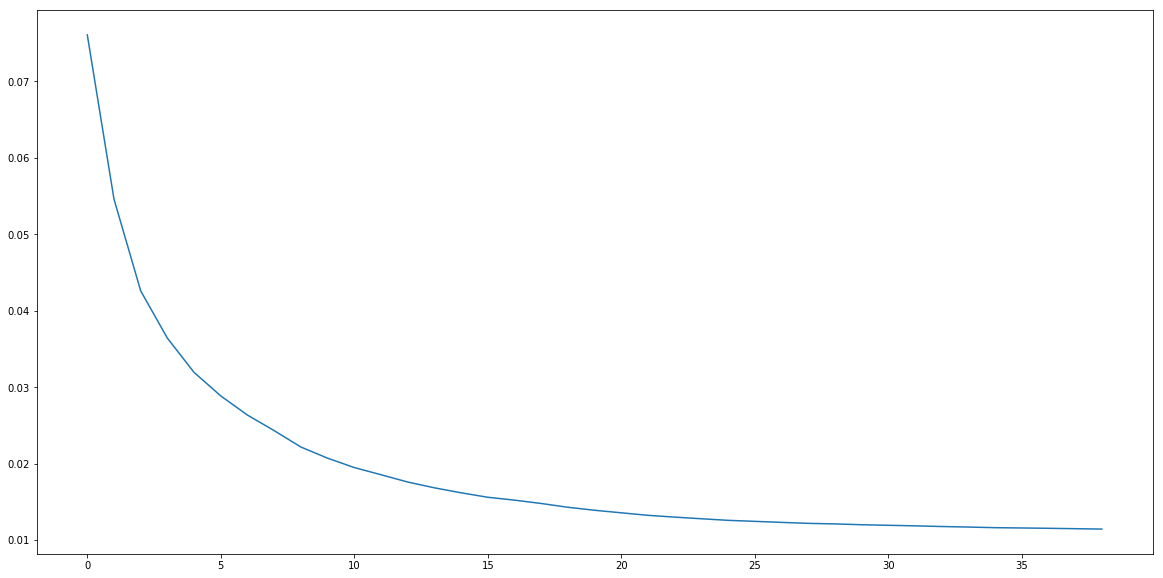

In [283]:
plt.plot(list_losses)

### Testing

In [284]:
list_xt_rim, losses = [], []
for (x0, y, x) in zip(X0_test, Y_test, X_test):
    list_xt, loss = rim.forward_sequence(x0, y, x, "test")
    list_xt_rim.append(list_xt)
    losses.append(loss.data.numpy()[0])
list_xt_rim = np.array(list_xt_rim)
losses = np.array(losses)

### Plotting

Loss: 0.012539


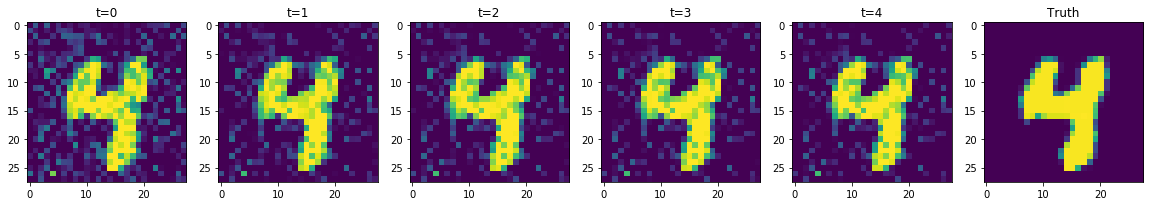

In [285]:
i_example = 48
t_final = 4

print("Loss: {0:5f}".format(float(losses[i_example])))

plt.rcParams['figure.figsize'] = (20,10)

for i in range(1,6):
    plt.subplot(1,6,i)
    plt.imshow(list_xt_rim[i_example][i-1].reshape(28,28), vmin=0, vmax=1)
    plt.title("t={}".format(i-1))
plt.subplot(1,6,6)
plt.imshow(X_test[i_example].reshape(28,28))
plt.title("Truth")

### Some statistics

#### Distribution of the distance between the last points and x

##### ... for x=x_true

In [ ]:
binwidth = 0.5

dist_rim = [np.linalg.norm(list_xt_rim[i][-1] - X_test[i]) for i in range(len(X_test))]
dist_gd = [np.linalg.norm(list_xt_gd[i][-1] - X_test[i]) for i in range(len(X_test))]

mean_rim = np.mean(dist_rim)
mean_gd = np.mean(dist_gd)

std_rim = np.std(dist_rim)
std_gd = np.std(dist_gd)

print("Average distance to true x with RIM: ", mean_rim)
print("Average distance to true x with GD: ", mean_gd)

print("STD distance to true x with RIM: ", std_rim)
print("STD distance to true x with GD: ", std_gd)

plt.subplot(1,2,1)
plt.title("RIM")
hist = plt.hist(dist_rim, bins=np.arange(min(dist_rim), max(dist_rim) + binwidth, binwidth))
# hist = plt.hist(dist_rim, bins=100)
plt.xlim(0,20)

plt.subplot(1,2,2)
plt.title("GD")
hist = plt.hist(dist_gd, bins=np.arange(min(dist_gd), max(dist_gd) + binwidth, binwidth))
# hist = plt.hist(dist_gd, bins=100)
plt.xlim(0,20)

##### ... for x=x_min

In [ ]:
dist_rim = [np.linalg.norm(list_xt_rim[i][-1] - X_min_test[i]) for i in range(len(X_test))]
dist_gd = [np.linalg.norm(list_xt_gd[i][-1] - X_min_test[i]) for i in range(len(X_test))]

mean_rim = np.mean(dist_rim)
mean_gd = np.mean(dist_gd)

std_rim = np.std(dist_rim)
std_gd = np.std(dist_gd)

print("Average distance to min x with RIM: ", mean_rim)
print("Average distance to min x with GD: ", mean_gd)

print("STD distance to min x with RIM: ", std_rim)
print("STD distance to min x with GD: ", std_gd)

plt.subplot(1,2,1)
plt.title("RIM")
hist = plt.hist(dist_rim, bins=np.arange(min(dist_rim), max(dist_rim) + binwidth, binwidth))
plt.xlim(0,20)

plt.subplot(1,2,2)
plt.title("GD")
hist = plt.hist(dist_gd, bins=np.arange(min(dist_gd), max(dist_gd) + binwidth, binwidth))
plt.xlim(0,20)

#### Average distance in function of time

##### ... to x=x_min

In [ ]:
dist_mean_rim = [np.mean([np.linalg.norm(list_xt_rim[i][t] - X_min_test[i]) for i in range(len(X_test))]) for t in range(time_max_rim)]
dist_mean_gd = [np.mean([np.linalg.norm(list_xt_gd[i][t] - X_min_test[i]) for i in range(len(X_test))]) for t in range(time_max_gd)]

dist_std_rim = [np.std([np.linalg.norm(list_xt_rim[i][t] - X_min_test[i]) for i in range(len(X_test))]) for t in range(time_max_rim)]
dist_std_gd = [np.std([np.linalg.norm(list_xt_gd[i][t] - X_min_test[i]) for i in range(len(X_test))]) for t in range(time_max_gd)]

plt.subplot(1,2,1)
plt.plot(dist_mean_rim, label="RIM")
plt.plot(dist_mean_gd, label="GD")
plt.legend()

plt.subplot(1,2,2)
plt.errorbar(np.arange(0,time_max_rim), dist_mean_rim, yerr=dist_std_rim, label="RIM")
plt.errorbar(np.arange(0,time_max_gd), dist_mean_gd, yerr=dist_std_gd, label="GD")
plt.legend()

##### ... to x=x_true

In [ ]:
dist_mean_rim = [np.mean([np.linalg.norm(list_xt_rim[i][t] - X_test[i]) for i in range(len(X_test))]) for t in range(time_max_rim)]
dist_mean_gd = [np.mean([np.linalg.norm(list_xt_gd[i][t] - X_test[i]) for i in range(len(X_test))]) for t in range(time_max_gd)]

dist_std_rim = [np.std([np.linalg.norm(list_xt_rim[i][t] - X_test[i]) for i in range(len(X_test))]) for t in range(time_max_rim)]
dist_std_gd = [np.std([np.linalg.norm(list_xt_gd[i][t] - X_test[i]) for i in range(len(X_test))]) for t in range(time_max_gd)]

plt.plot(dist_mean_rim, label="RIM")
plt.plot(dist_mean_gd, label="GD")
plt.legend()

In [ ]:
hist = plt.hist(X_min_train, bins=100)
# plt.xlim(-5,5)

In [ ]:
hist = plt.hist(X_train)